In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np, pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

%matplotlib inline

In [2]:
df = pd.read_csv('./datasets/abalone.csv', index_col=0)

In [3]:
# dataframe을 split하는 것도 가능함
df_train, df_test = train_test_split(df,
                                     test_size=0.2,
                                     random_state=42)

print(f"Training data size: {df_train.shape}")
print(f"Test data size: {df_test.shape}")

Training data size: (3341, 9)
Test data size: (836, 9)


In [4]:
df_train.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
id,,,,,,,,,
4038,I,0.550,0.445,0.125,0.6720,0.2880,0.1365,0.210,11
1272,I,0.475,0.355,0.100,0.5035,0.2535,0.0910,0.140,8
3384,F,0.305,0.225,0.070,0.1485,0.0585,0.0335,0.045,7
3160,I,0.275,0.200,0.065,0.1165,0.0565,0.0130,0.035,7
3894,M,0.495,0.380,0.135,0.6295,0.2630,0.1425,0.215,12


In [5]:
def plot_numerics(data):
    numeric_columns = data.columns
    # Plotting histgrams and box plots for each numeric column
    for column in numeric_columns:
        _, ax = plt.subplots(1, 2, figsize=(16, 5))
        ax = ax.flatten()

        # Histogram
        sns.histplot(data[column], 
                     bins=50, 
                     kde=True, color='skyblue', ax=ax[0])
        ax[0].set_title(f'Histogram of {column}', fontsize=15, fontweight='bold')
        ax[0].set_xlabel(column, fontsize=12)
        ax[0].set_ylabel('Frequency', fontsize=12)

        # Boxplot
        sns.boxplot(x=data[column], color='lightgreen', ax=ax[1])
        ax[1].set_title(f'Box plot of {column}', fontsize=15, fontweight='bold')
        ax[1].set_xlabel(column, fontsize=12)

        plt.tight_layout()
        plt.show()

In [6]:
def get_count_plot(cat):
    ax = sns.countplot(x=df_train[cat],
                       order=df_train[cat].value_counts(ascending=False).index);
    abs_values = df_train[cat].value_counts(ascending=False)
    rel_values = df_train[cat].value_counts(ascending=False, normalize=True).values * 100
    
    lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

    ax.bar_label(container=ax.containers[0], labels=lbls)
    ax.set_title("Distribution of "+cat+" Values",fontsize=16)

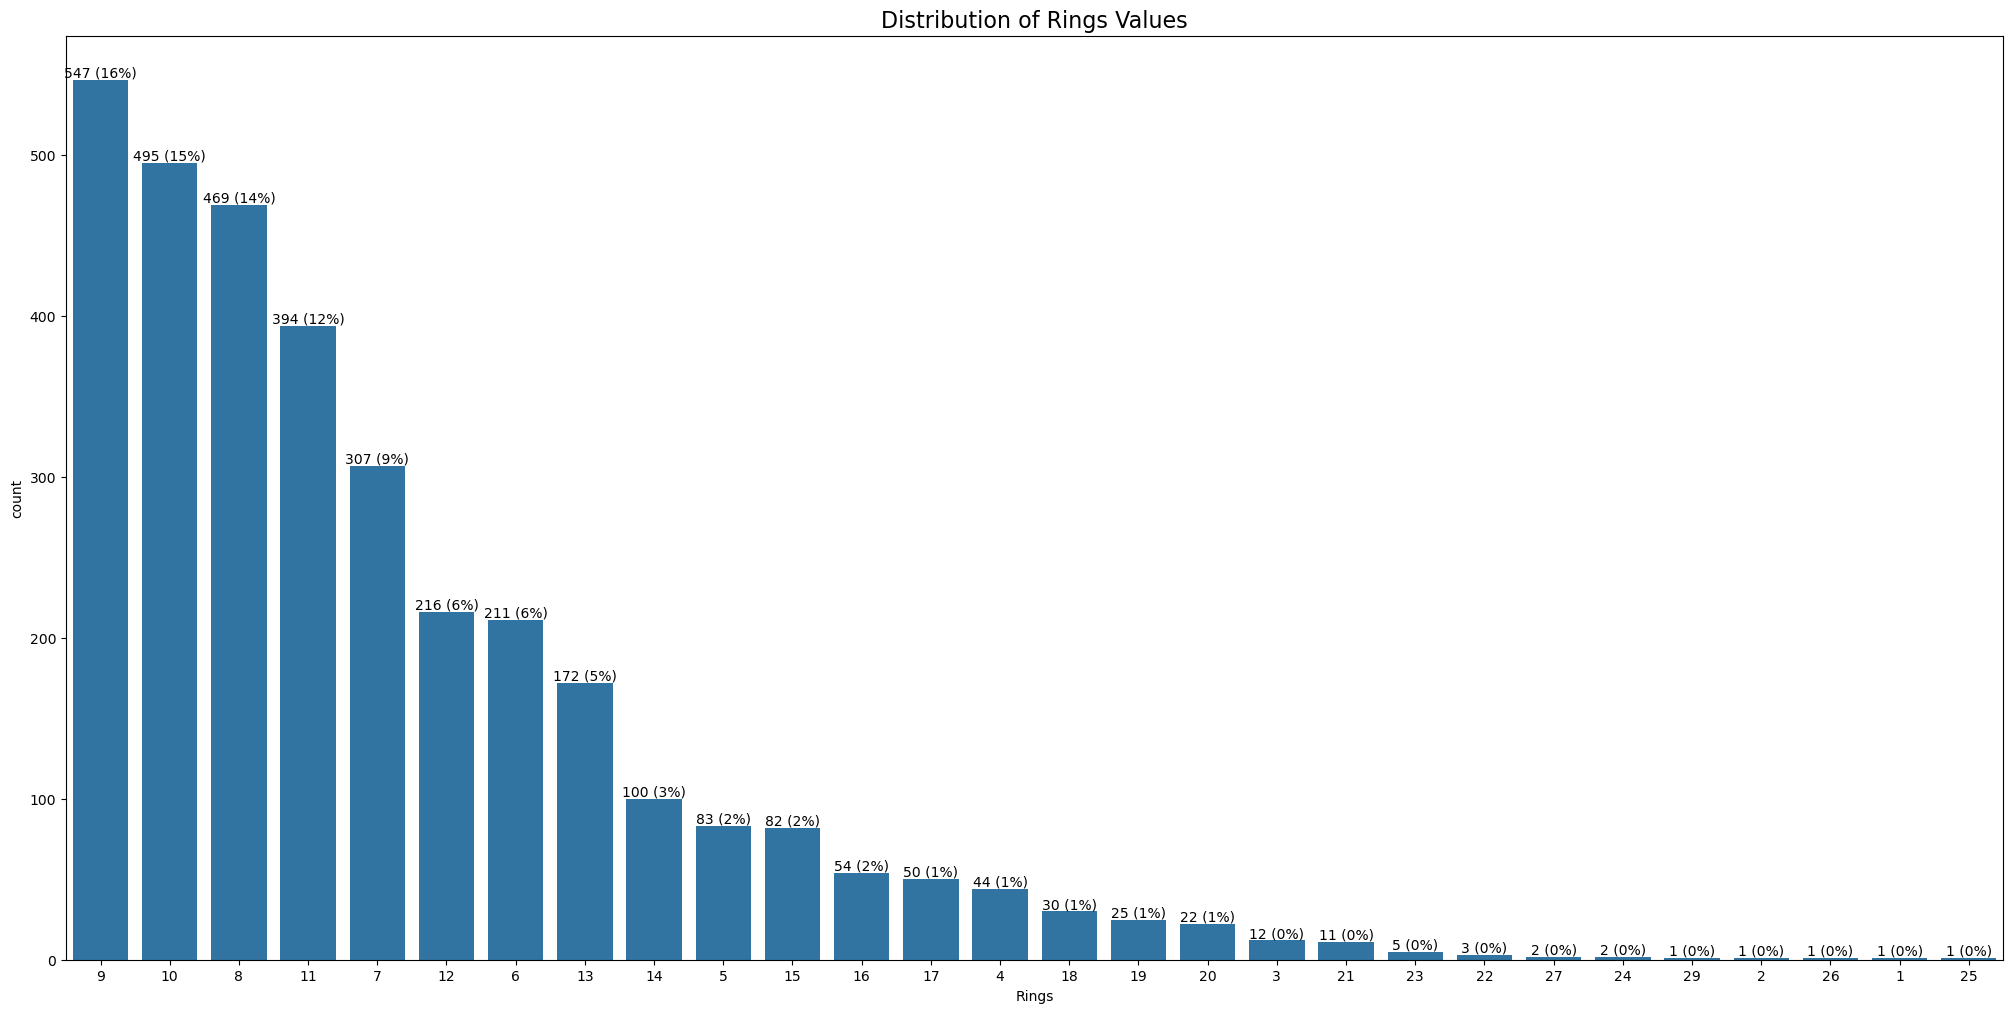

In [7]:
plt.figure(figsize=(25, 12))
get_count_plot('Rings')

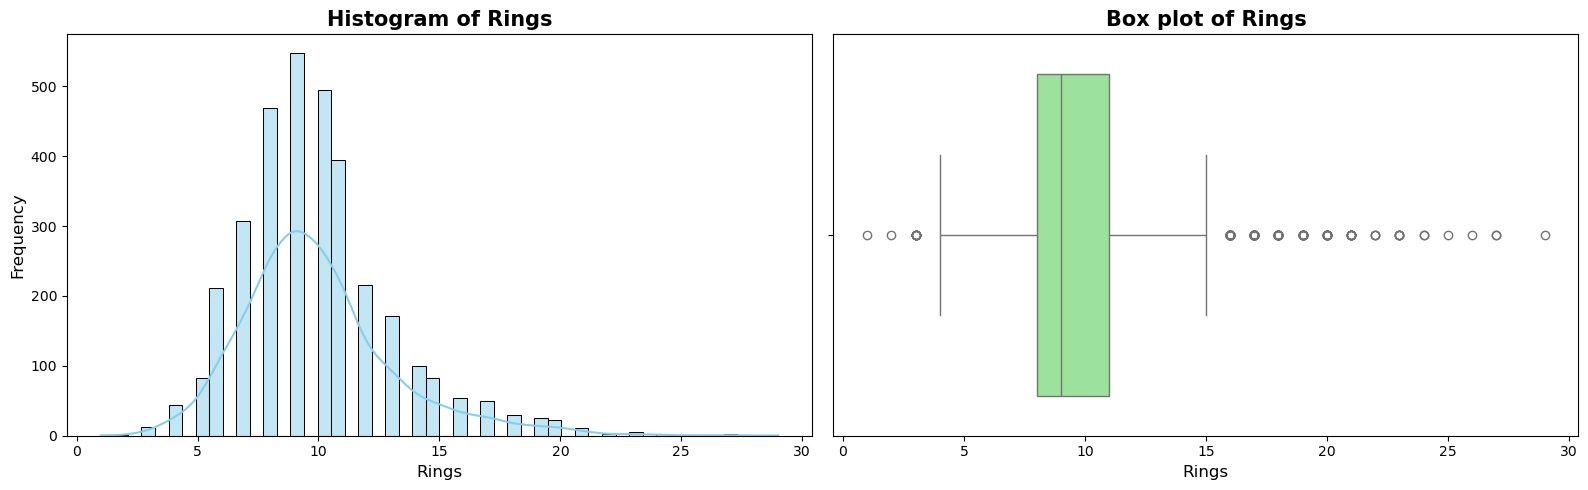

In [8]:
plot_numerics(df_train[['Rings']])

In [9]:
df_train.columns

Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight',
       'Viscera_weight', 'Shell_weight', 'Rings'],
      dtype='object')

In [10]:
# features description
'''
Sex              | M, F, and I(infant)          | 수컷, 암컷, 미성숙함(구분 불가)
Length           | Longest shell measurement    | 껍질의 장축 길이
Diameter         | perpendicular to length      | 껍질의 단축 길이
Height           | with meat in shell           | 높이(껍질 외에도 살 부분을 포함)
Whole_weight     | whole abalone                | 껍질 + 살 무게
Shucked_weight   | weight of meat               | 껍질을 제외한 살 무게
Viscera_weight   | gut weight(after bleeding)   | 피를 뺀 후의 내장 무게
Shell_weight     | after being dried            | 건조 후의 껍질 무게
Rings            | +1.5 gives the age in years  | 껍질의 ring의 수, 1.5를 곱하면 실제 나이
'''

'\nSex              | M, F, and I(infant)          | 수컷, 암컷, 미성숙함(구분 불가)\nLength           | Longest shell measurement    | 껍질의 장축 길이\nDiameter         | perpendicular to length      | 껍질의 단축 길이\nHeight           | with meat in shell           | 높이(껍질 외에도 살 부분을 포함)\nWhole_weight     | whole abalone                | 껍질 + 살 무게\nShucked_weight   | weight of meat               | 껍질을 제외한 살 무게\nViscera_weight   | gut weight(after bleeding)   | 피를 뺀 후의 내장 무게\nShell_weight     | after being dried            | 건조 후의 껍질 무게\nRings            | +1.5 gives the age in years  | 껍질의 ring의 수, 1.5를 곱하면 실제 나이\n'

In [11]:
# feature engineering
# 전체(껍질 + 살) 무게 중 순수 살 무게의 비율을 나타내는 feature를 만듦
df_train['Whole_weight_Ratio'] = df_train['Shucked_weight'] / df_train['Whole_weight']

In [12]:
# categorical columns
cat_cols = ['Sex']
# numerical columns
num_cols = ['Length', 'Diameter', 'Height',
            'Whole_weight', 'Shucked_weight',
            'Viscera_weight', 'Shell_weight', 'Whole_weight_Ratio']

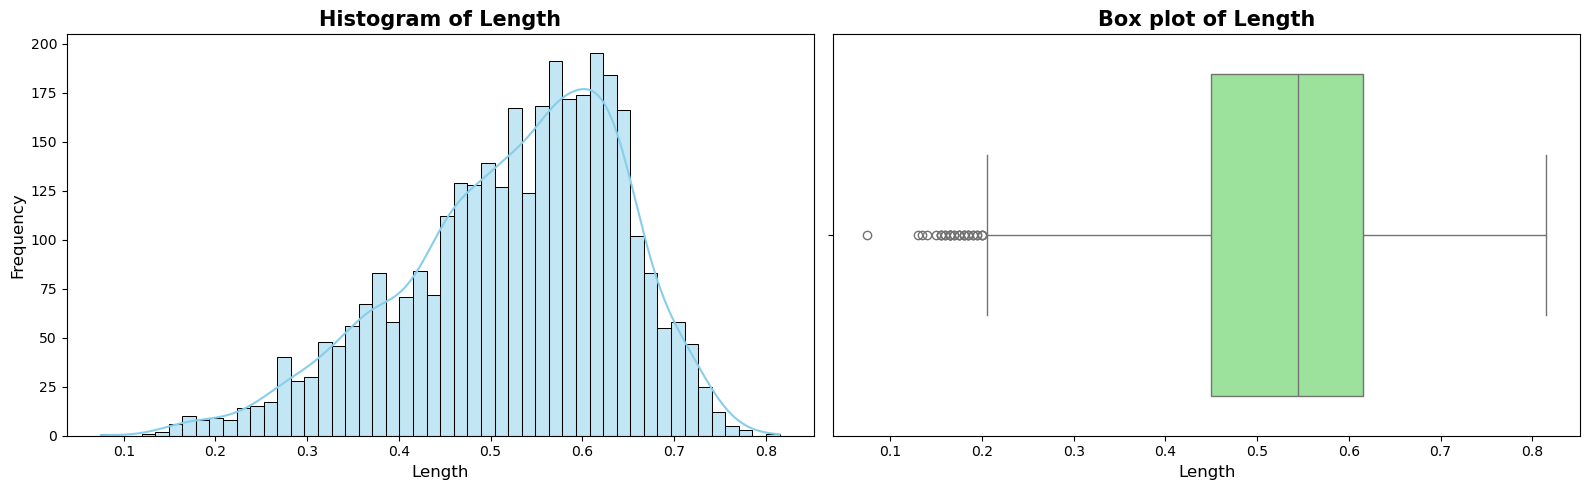

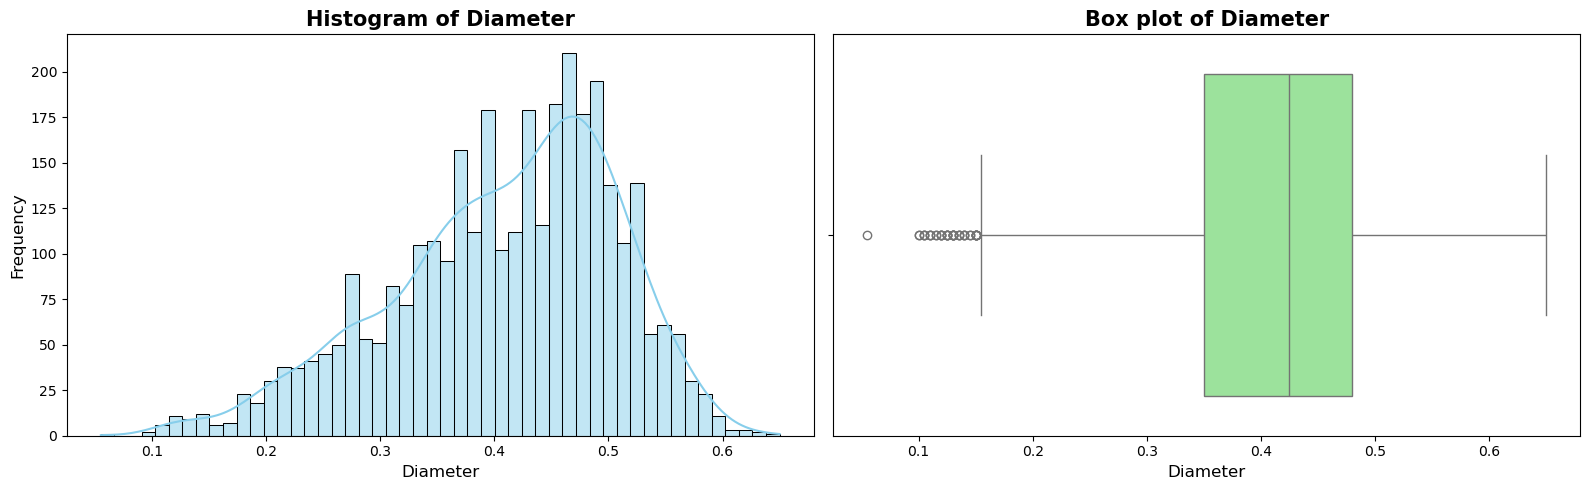

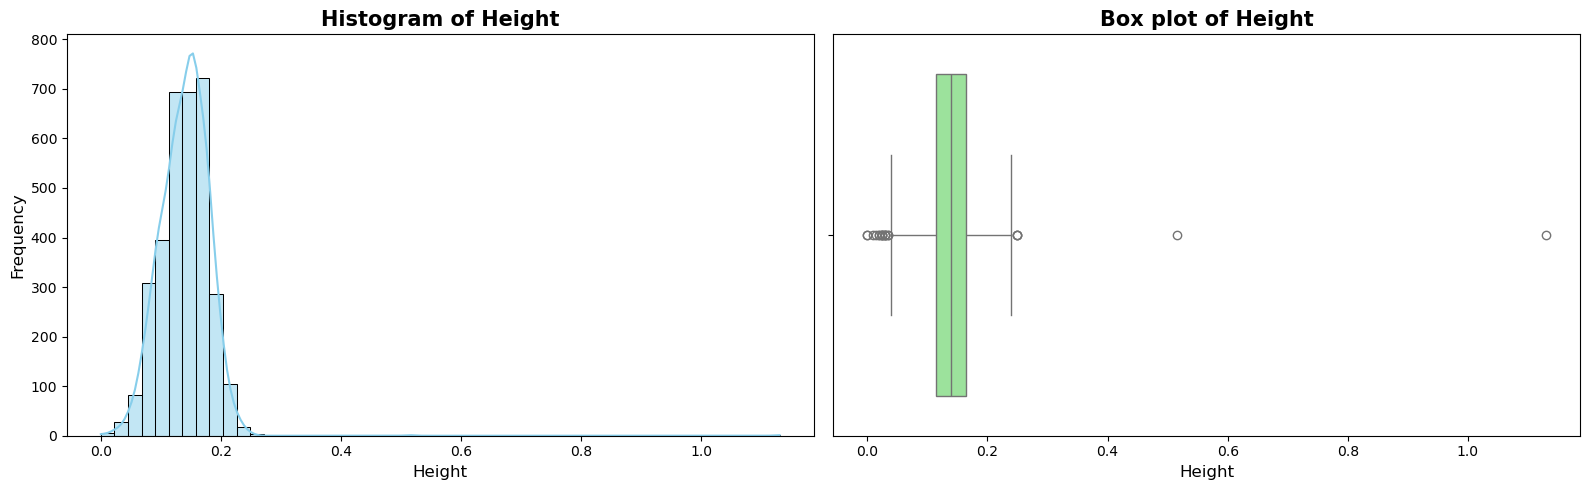

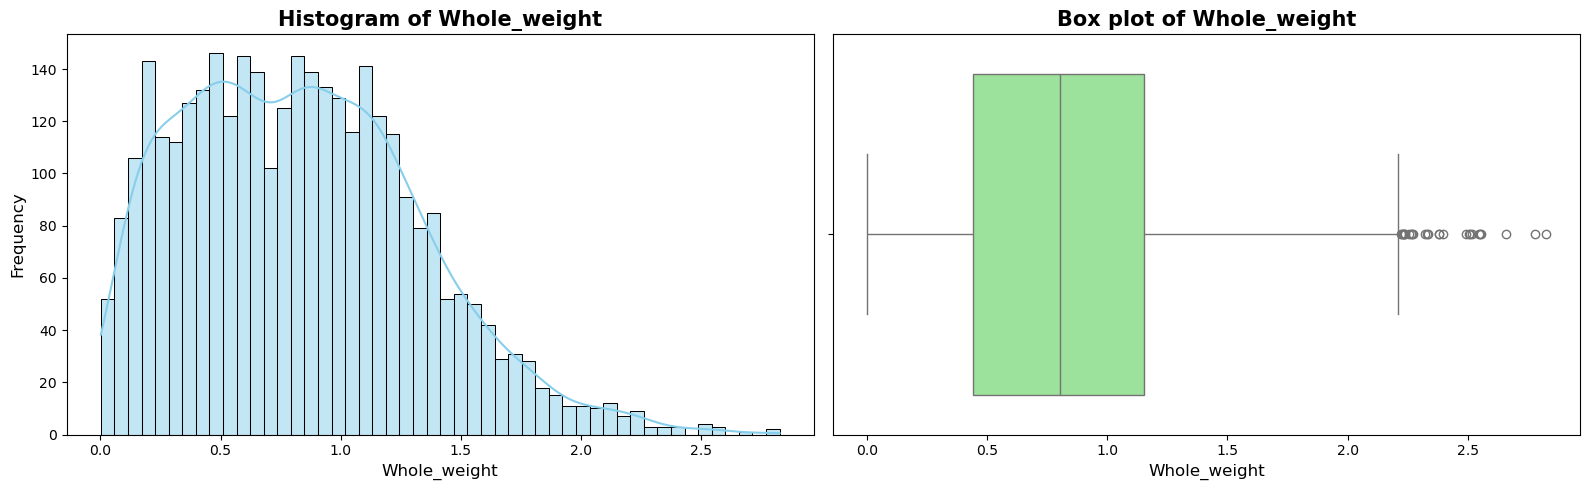

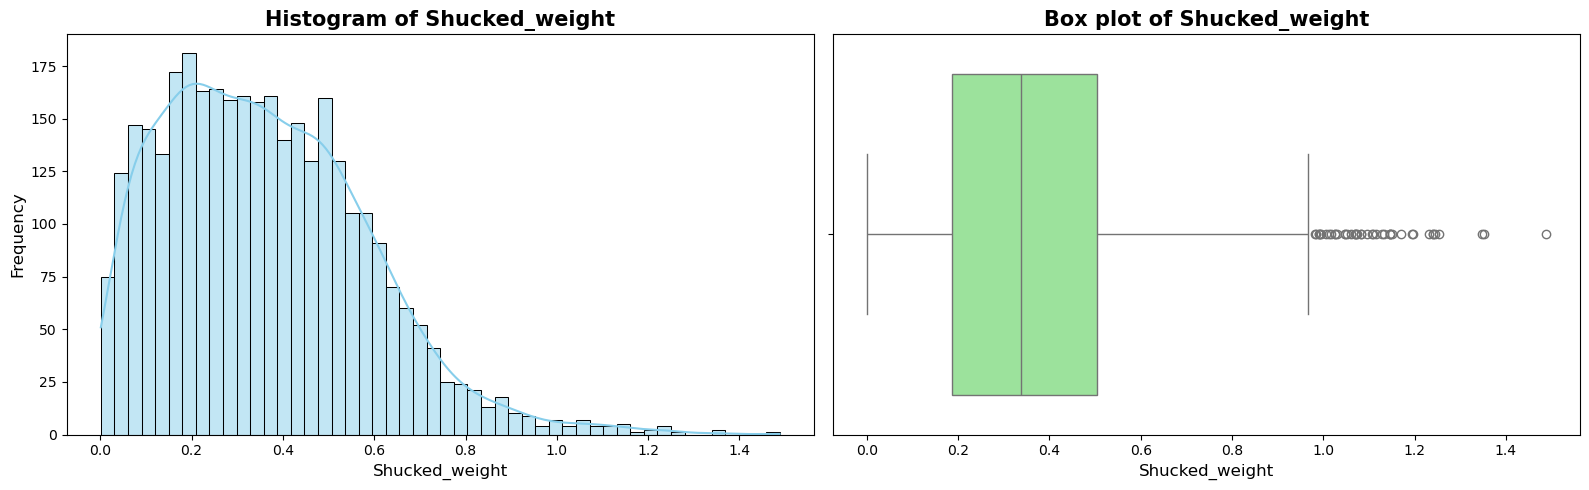

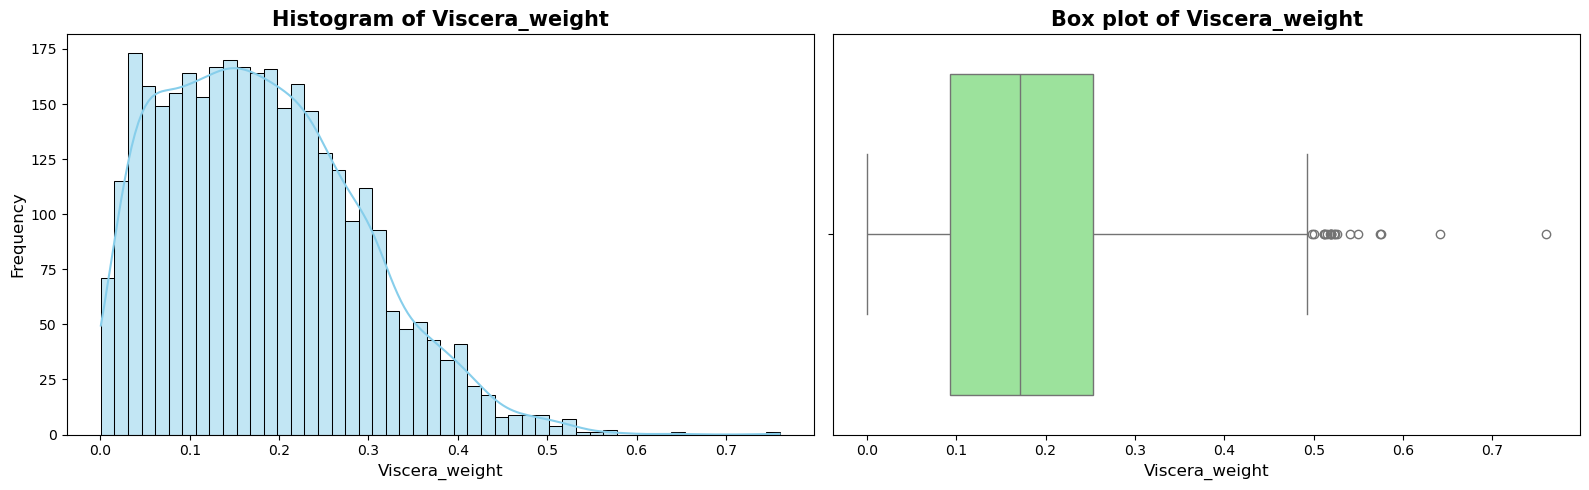

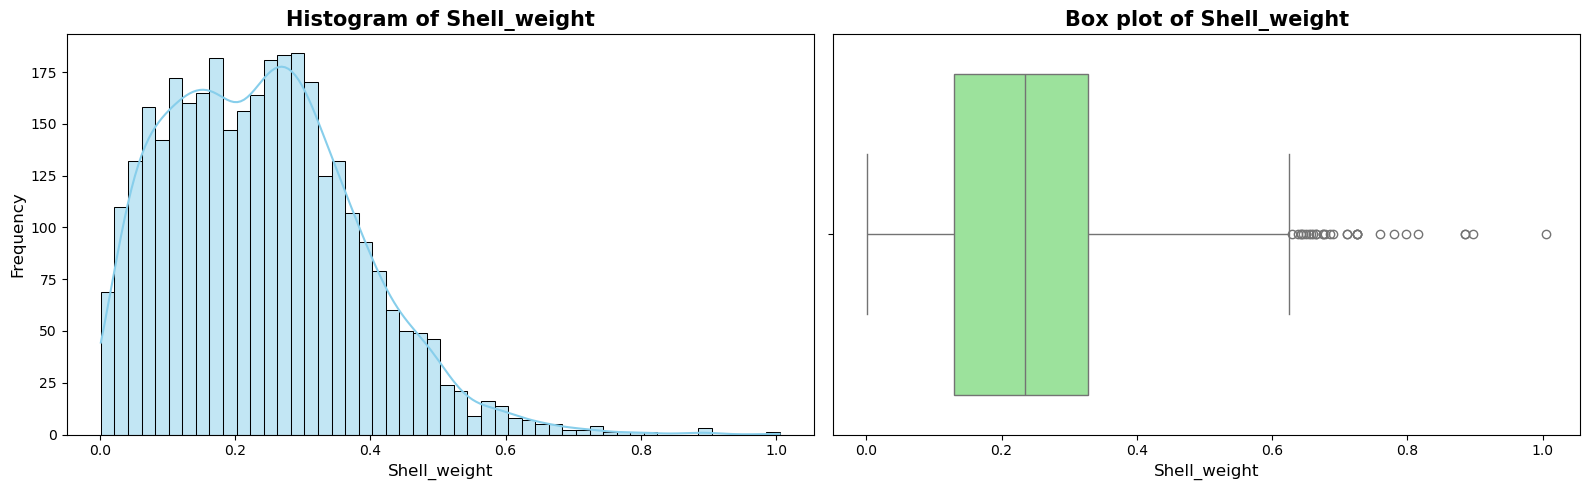

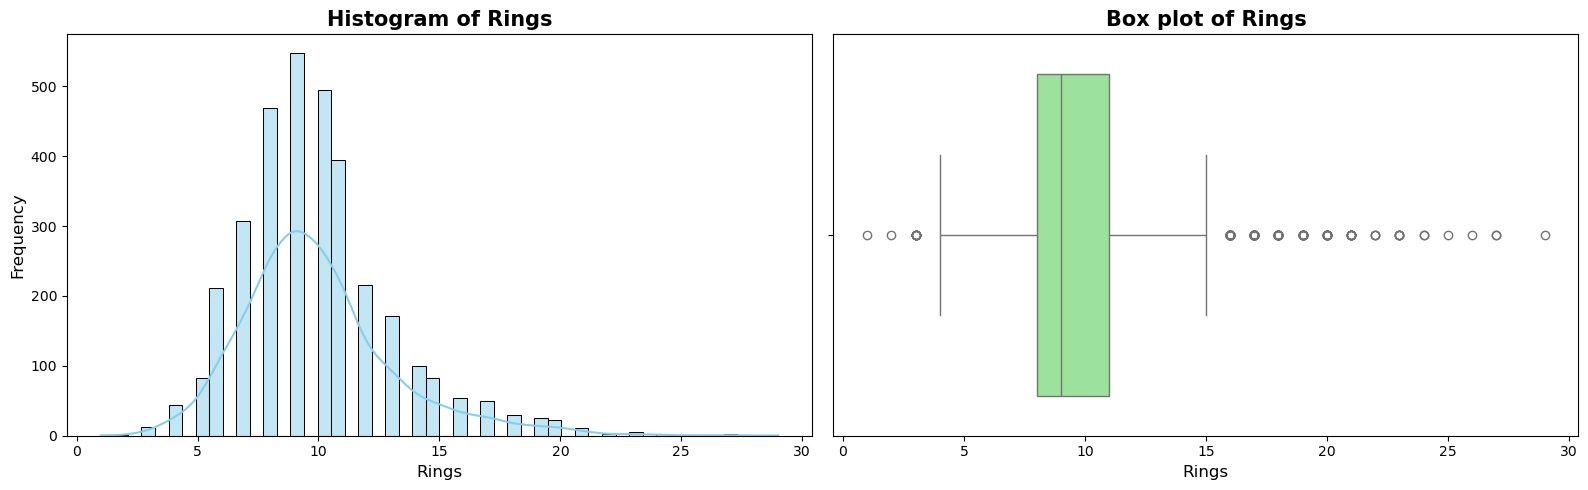

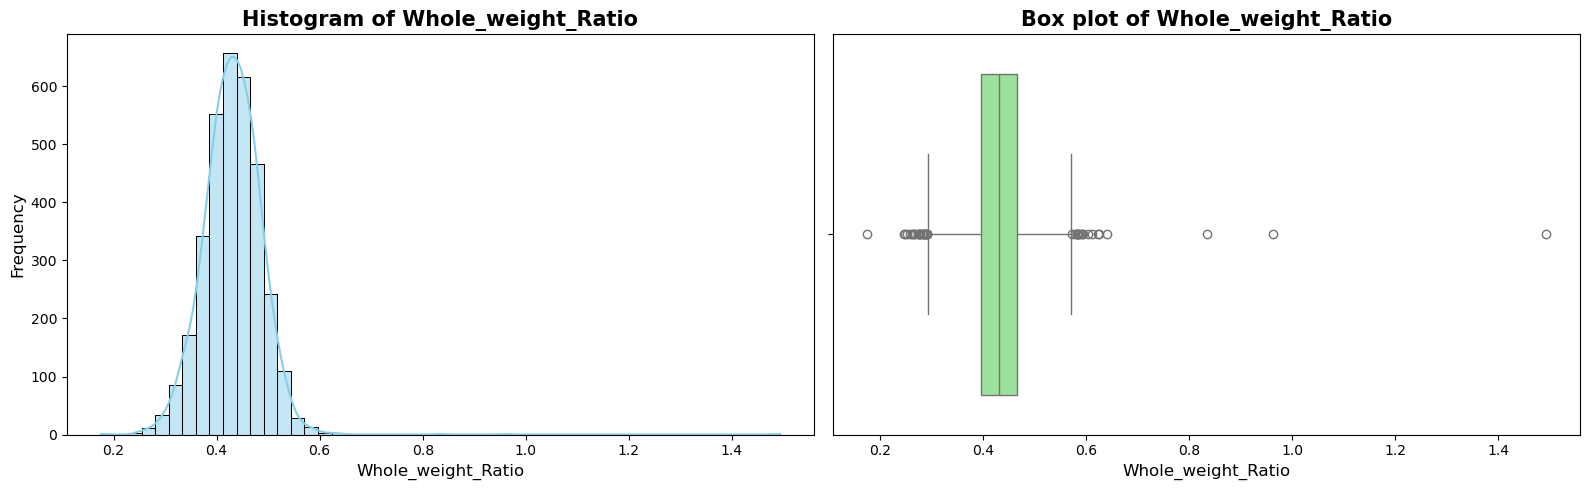

In [13]:
plot_numerics(df_train.drop('Sex', axis=1))

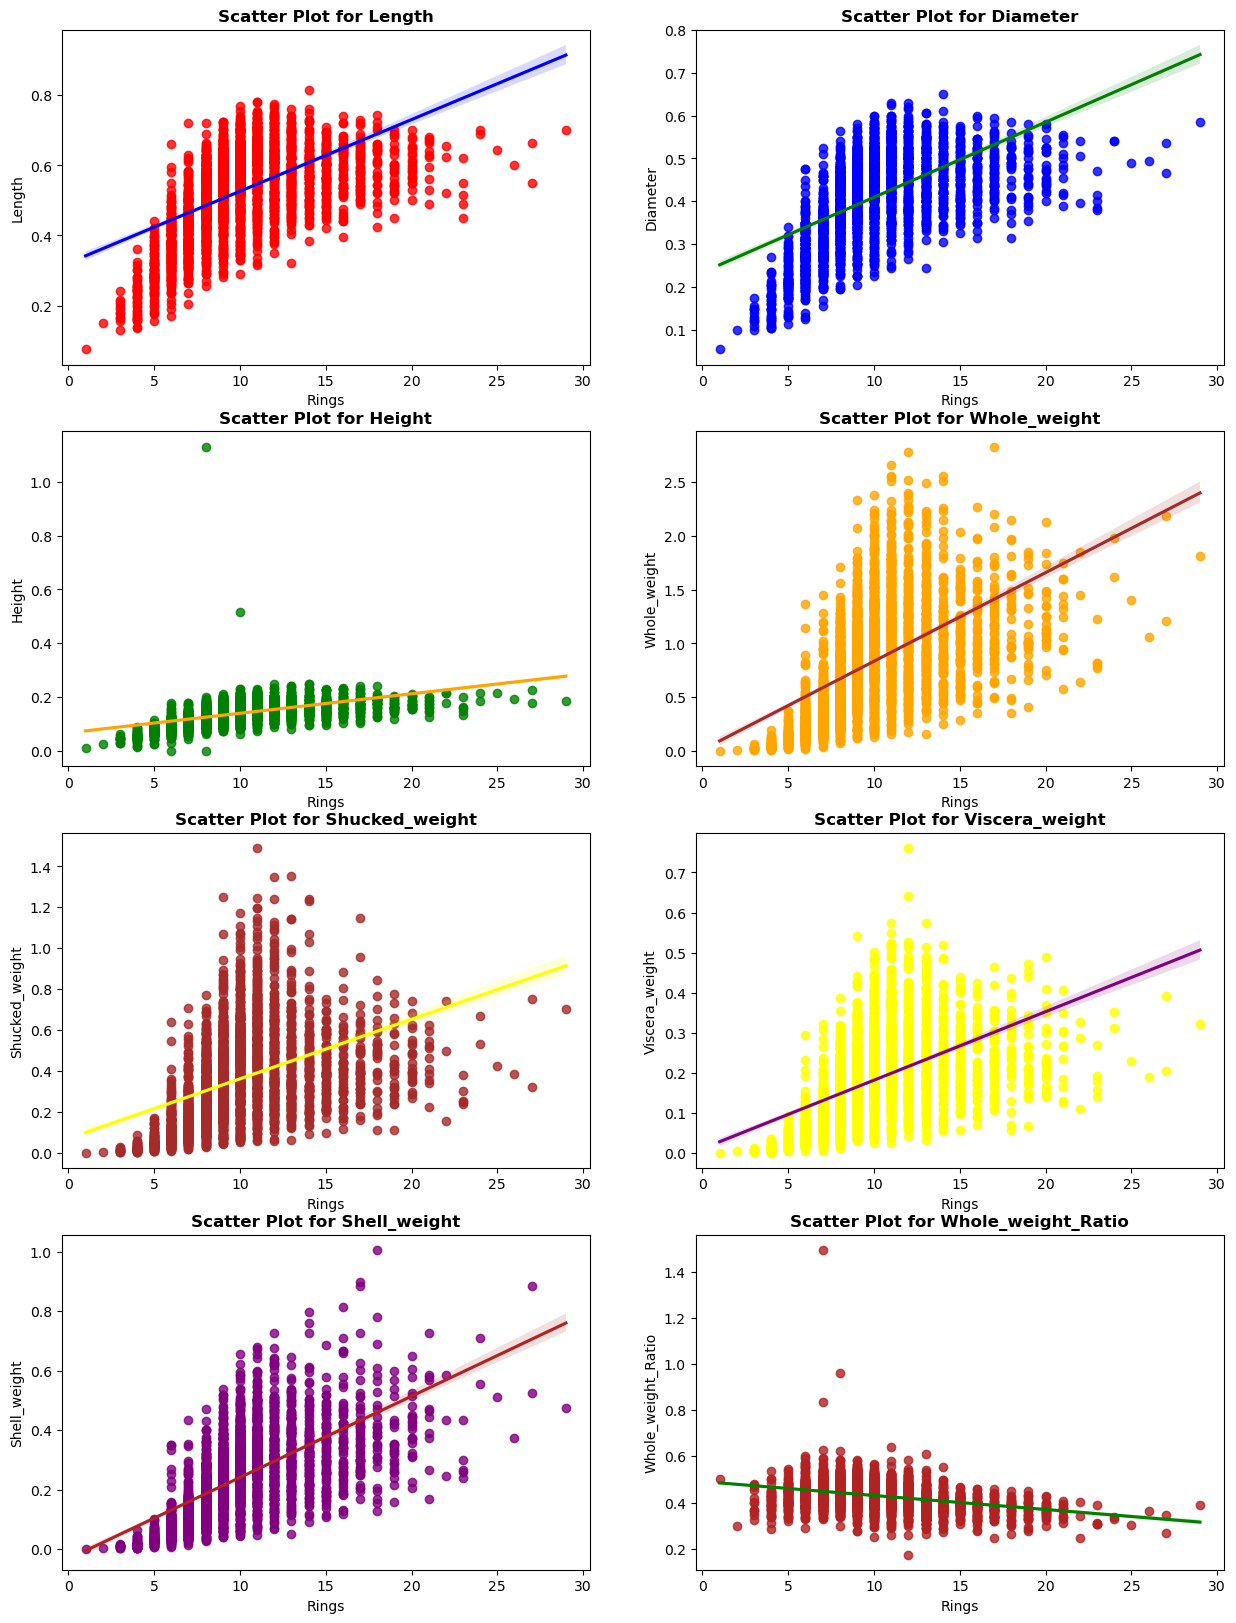

In [14]:
# Determine the size of the grid
n_cols = 2 # Number of columns in the subplot grid <- user define
n_rows = int(np.ceil(len(num_cols) / n_cols)) # Calculate the number of rows needed

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axs = axs.flatten() if (n_rows > 1) else [axs]

colors = ['red', 'blue', 'green', 'orange', 'brown', 'yellow', 'purple', 'firebrick', 'green']

for i, ncol in enumerate(num_cols):
    sns.regplot(data=df_train, 
                x='Rings', y=ncol,
                ax=axs[i],
                color=colors[i],
                line_kws=dict(color=colors[i+1]))
    axs[i].set_title(f'Scatter Plot for {ncol}', fontweight='bold')

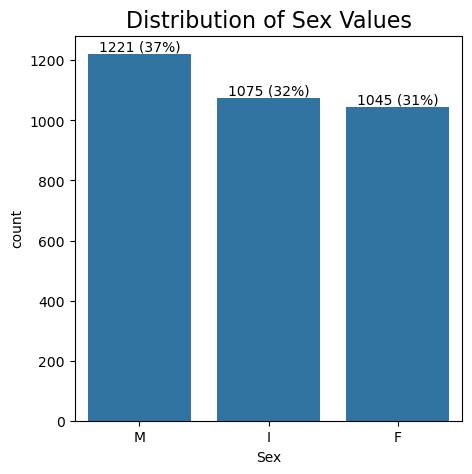

In [15]:
plt.figure(figsize=(5, 5))
get_count_plot('Sex')

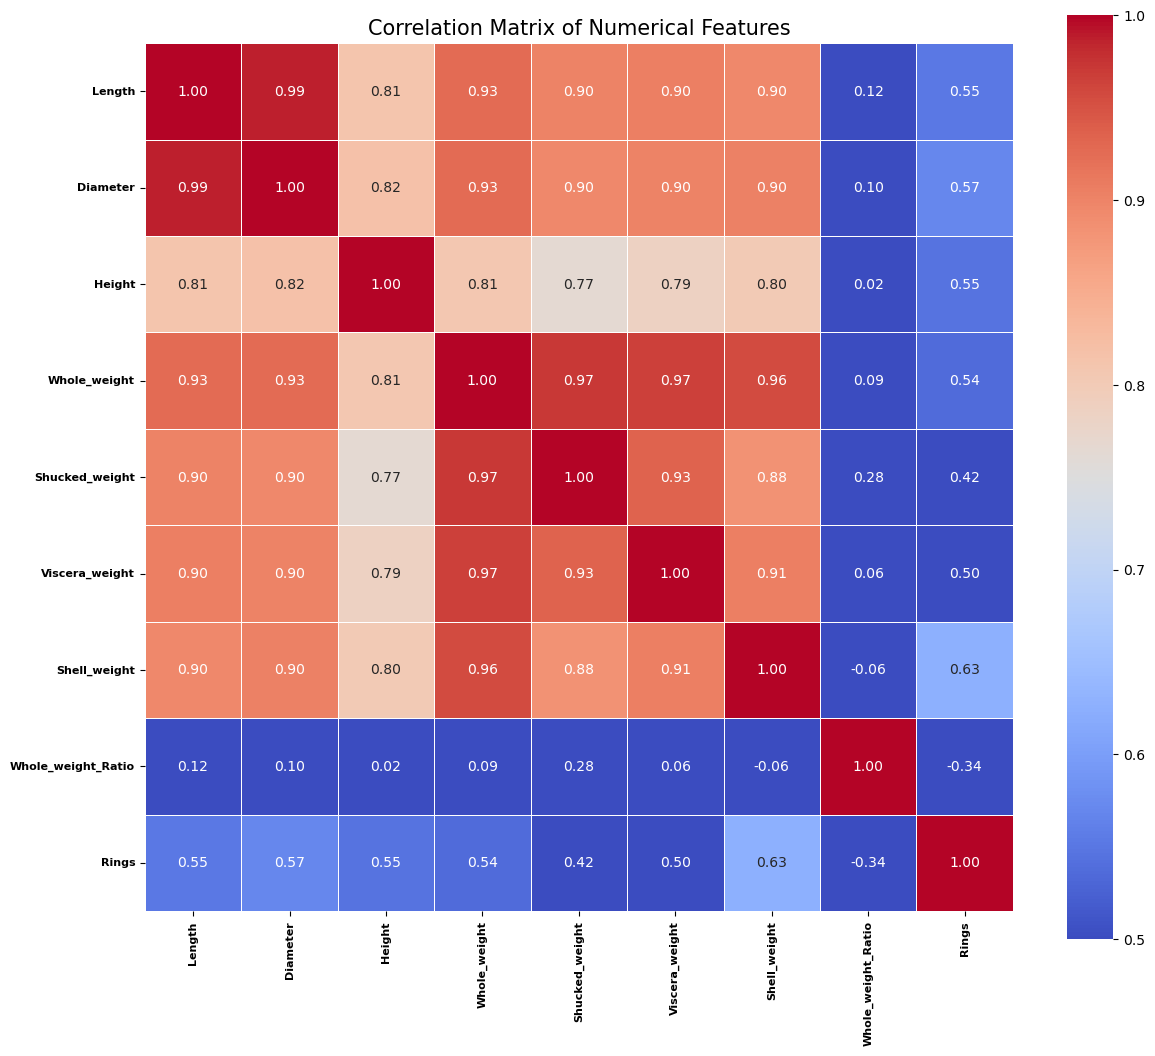

In [16]:
corr_matrix = df_train[num_cols+['Rings']].corr()
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, vmax=1, vmin=0.5, center=0.75,annot=True, fmt=".2f", square=True, 
            linewidths=.5, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features', fontsize=15)
plt.xticks(fontsize=8,fontweight='bold')
plt.yticks(fontsize=8,fontweight='bold')
plt.show()

In [17]:
# correlation이 0.55 이하인 feature들은 버림
num_cols = ['Length', 'Diameter', 'Height', 'Whole_weight_Ratio']

In [18]:
def get_features(df):
    # feature engineering
    df['Whole_weight_Ratio'] = df['Shucked_weight'] / df['Whole_weight']
    # 기존 feature를 log scaling
    df['Shell_weight'] = np.log(1e-5 + df['Shell_weight'])
    df['Whole_weight'] = np.log(1e-5 + df['Whole_weight'])
    df['Shucked_weight'] = np.log(1e-5 + df['Shucked_weight'])
    df['Viscera_weight'] = np.log(1e-5 + df['Viscera_weight'])

    # categorical_String value인 'Sex' column을 categorical_numeric으로 mapping
    sex_dict = {'I' : 0, 'M' : 1, 'F' : 2}
    df['Sex'] = df['Sex'].map(sex_dict)

    # StandardScaler 사용
    # 이때 'Sex'는 numerical하게 매핑했지만, 여전히 categorical이므로 적용하지 않음
    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])

    return df

In [19]:
# train과 test를 합칠 건데 누가 누구인지 구분하기 위해서 
# train은 0, test는 1로 지정한 임시 column 생성
df_train['type'] = 0
df_test['type'] = 1

df_all = pd.concat([df_train, df_test], axis=0)
df_all = get_features(df_all)

df_all.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,Whole_weight_Ratio,type
id,,,,,,,,,,,
4038,0,0.216591,0.374075,-0.347099,-0.397482,-1.244760,-1.991357,-1.560600,11,-0.036338,0
1272,0,-0.408000,-0.532927,-0.944870,-0.686152,-1.372352,-2.396786,-1.966041,8,0.671962,0
3384,2,-1.823741,-1.843041,-1.662195,-1.907103,-2.838558,-3.395911,-3.100871,7,-0.363821,0
3160,0,-2.073577,-2.094986,-1.781749,-2.149778,-2.873338,-4.342037,-3.352122,7,0.497052,0
3894,1,-0.241443,-0.280982,-0.107991,-0.462814,-1.335563,-1.948343,-1.537071,12,-0.138270,0


In [20]:
# train과 test로 다시 분리
df_train = df_all[df_all['type'] == 0]
df_test = df_all[df_all['type'] == 1]

X_train = df_train.drop(['Rings', 'type'], axis=1)
y_train = df_train['Rings']
y_logged = np.log(1+y_train)

X_test = df_test.drop(['Rings', 'type'], axis=1)
y_test = df_test['Rings']


In [21]:
features = list(X_train.columns)
features

['Sex',
 'Length',
 'Diameter',
 'Height',
 'Whole_weight',
 'Shucked_weight',
 'Viscera_weight',
 'Shell_weight',
 'Whole_weight_Ratio']

In [22]:
# Set a hyperparameters
params={'metric':'rmse',
        'verbosity':-1,
        'n_estimators': 600, 
        'learning_rate': 0.04354995869675832, 
        'subsample': 0.719764026033712,
        'colsample_bytree': 0.5593947251633323, 
        'min_data_in_leaf': 71, 
        'lambda_l1': 0.014080963948076265, 
        'lambda_l2': 0.04806381049807052,
        'max_depth': 16, 
        'min_child_samples': 34}

In [23]:
LGB = lgb.LGBMRegressor(**params)
LGB.fit(X_train, y_train)

  File "C:\Users\komando\miniconda3\envs\gc_ml_tf\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\komando\miniconda3\envs\gc_ml_tf\lib\subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\komando\miniconda3\envs\gc_ml_tf\lib\subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\komando\miniconda3\envs\gc_ml_tf\lib\subprocess.py", line 1436, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


LGBMRegressor(colsample_bytree=0.5593947251633323,
              lambda_l1=0.014080963948076265, lambda_l2=0.04806381049807052,
              learning_rate=0.04354995869675832, max_depth=16, metric='rmse',
              min_child_samples=34, min_data_in_leaf=71, n_estimators=600,
              subsample=0.719764026033712, verbosity=-1)

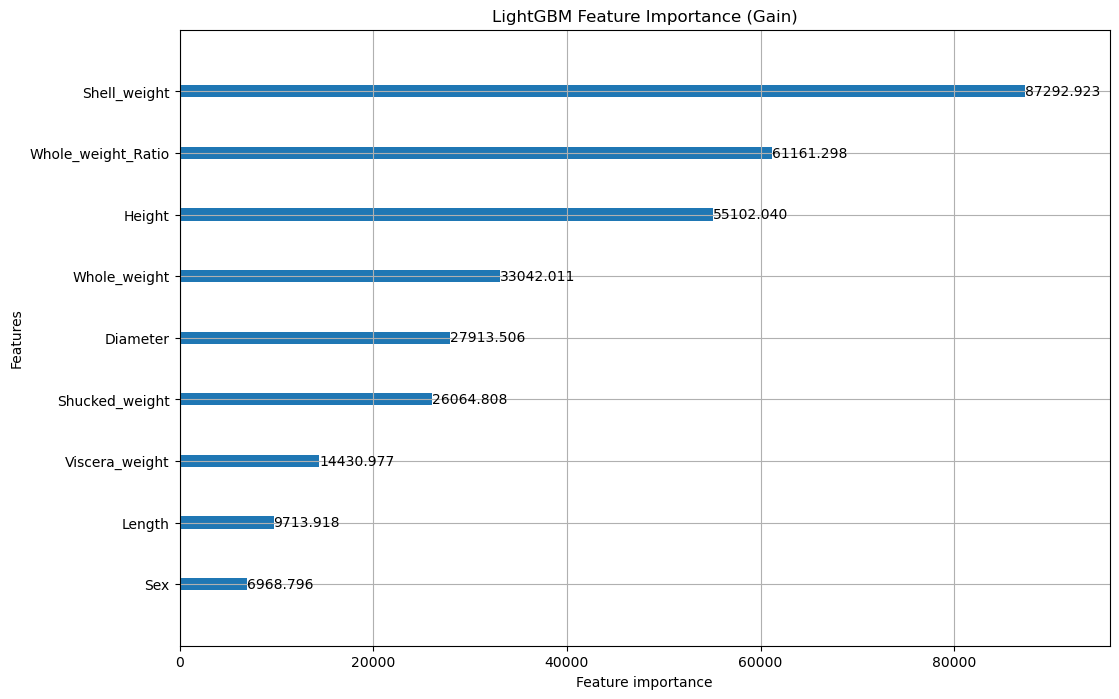

In [24]:
lgb.plot_importance(LGB, importance_type="gain", figsize=(12,8), max_num_features=12,
                    title="LightGBM Feature Importance (Gain)")
plt.show()

In [25]:
# 예측값 계산
y_pred = LGB.predict(X_train)

# MSE (Mean Squared Error) 계산
mse = mean_squared_error(y_train, y_pred)

# MSE 출력
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 2.078507963461163


In [26]:
# 예측값 계산
y_pred = LGB.predict(X_test)

# MSE (Mean Squared Error) 계산
mse = mean_squared_error(y_test, y_pred)

# MSE 출력
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 4.938741009140508


LGBMRegressor는 LightGBM(Light Gradient Boosting Machine) 라이브러리에서 제공하는 회귀 모델입니다. 이는 Gradient Boosting 알고리즘의 변형으로, 특히 빠른 학습 속도와 효율적인 메모리 사용으로 잘 알려져 있습니다. 주로 대용량 데이터셋에서 효과적으로 작동하며, 높은 예측 성능을 자랑합니다.

주요 특징:
Gradient Boosting 알고리즘 기반: LightGBM은 일반적으로 Gradient Boosting Decision Tree(GBDT) 방식에 기반하여 작동하며, 여러 개의 약한 예측 모델(주로 결정 트리)을 결합하여 강력한 예측 모델을 만듭니다.

-> 내 기억에 아마 Gradient Boosting DT가 sample 한 개씩 빼서 학습하는 모델로 알고있음. 따라서 각 클래스에 속하는 샘플을 비교적 균등하게 뽑아서 훈련할 수 있기 때문에 좋은 성능이 나오는듯